# Numerical Solutions to the Thermodynamics of an Ideal Fermi Gas:
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/hariseldon99/StatmechCodes/master?filepath=FinSize_Therm.ipynb)
## Introduction
This jupyter notebook numerically computes the partition function $Z(\beta)$ for examples of systems with a finite number of single particle levels (e.g., $2-$level, $3-$level, etc.) and a finite number of non-interacting particles $N$ under Fermi-Dirac and Bose- Einstein statistics. The Maxwell-Boltzmann case is left to the reader as an exercise. This partition function will then be used to investigate the dependence of average energy, energy fluctuation and specific heat. You can change the number of particles $N$ and number of states $K$ to obtain different plots for the average energy per particle and specific heat.

## Description
Given that a system has $N$ particles in $K$ single-particle states, we first construct the ensemble of allowed states. If the energy of the $r^{th}$ many body state in the ensemble is $E_r$, then the partition function, in the canonical ensemble, is given by [1]

$$
Z(\beta) = \sum_r e^{-\beta E_r}.
$$ 

The partition function, average energy, and specific heat for this ensemble are given by [1] 
$$
Z = \sum_r e^{-\beta E_r},\\
\overline{E}  = -\frac{\partial}{\partial \beta}\ln{Z},\\
C_v \equiv \frac{\partial\overline{E}}{\partial T} =  -\beta^2\frac{\partial\overline{E}}{\partial\beta} = \beta^2 \frac{\partial^2}{\partial\beta^2}\ln{Z}.
$$

Note that Boltzmann constant has been set to unity.

Let us first construct the Bose-Einstein ensemble. Here, all states can accommodate up to $N$ particles. The ensemble can be represented by a matrix with all the possible combinations of number totalling to $N$ with repetition. In other words, each row of the matrix is a unique Fock state in the occupation number representation.

For concreteness, let's go with an example of $K = 4$ and $N=3$. For simplicity, let us set the single particle energies to that of the so-called "Einstein Solid" (like in Einstein's Theory of Specific Heat [1]) *i.e* the $m^{th}$ single particle energy $\epsilon_m = m\hbar\omega$ . If we set $\hbar\omega=1$, an array of single particle energies can readily be constructed as an array of consecutive non-negative integers.

In order to construct the statistical ensemble, think of placing $3$ 'dividers' into a row of $3$ identical 'particles': those dividers then divide the particles into $4$ groups (some of them may be empty), and one can read off the length of each group. So all we need to do is enumerate all ways of placing those dividers. This can be readily done using combination tools from python [2] and has been implemented in the function 'partitions' defined inthe code below. The output is a matrix of size $P\times K$, where $P$ is the total number of states, given by

$$
P = \frac{\left(N+K-1\right)!}{N!\left(K-1\right)!} = 15,
$$

and each $K-$ size row represents a fock state of the type $|n_1, n_2, \dots, n_K\rangle$ with $n_i$ particles in state $i$. This constructs a full Bose-Einstein ensemble of allowed states.and stores it in a matrix. You can experiment with this by setting different values of $N$ and $K$ and running

    ensemble = partitions(N,K)
    print(ensemble)

Nest, the corresponding Fermi-Dirac ensemble can be created by copying the Bose-Einstein ensemble and deleting any row (fock state) that has more than $g=2s+1$ particles for spin $s$, where $g$ is the spin degeneracy. We've set the spin to $1/2$ by default (electrons), but you can change it if you wish. Next, these ensembles are fed into the partition function (implemented in the code below by the function 'PartFn') where, for a particular inv-temperature $\beta$ and set of single particle energies, the partition function can be computed using simple dot products on the arrays/matrices. Then, for a given range of $\beta$'s (stored in the variable 'betas' in the code below), the partition function is computed and differentiated numerically using 'numpy.gradient' [3] to obtain arrays for the energies and specific heats.

The sample output below comes from $N=6$ particles in $K=4$ states. Notice that the average energy for the Fermi-Dirac case asymptotically approaches a non-zero value as $\beta\rightarrow\infty$ ($T\rightarrow 0$) while the average energy asymptotically vanishes for the Bose-Einstein case. This happens due to the Pauli exclusion principle, which prevents the population of many particles in the ground state, forcing them into higher energy states [1], unlike a Bose gas. Also note that the specific heats for both types of gases are peaked, but the peak is much sharper for the Bose gas than the Fermi gas (why?).

## References
1. Reichl, L.E (1998), *A Modern Course in Statistical Physics (2nd ed.)*. JOHN WILEY & SONS, INC. ISBN:0-471-59520-9 .
2. See documentation for python's [itertools combinations with replacement](https://docs.python.org/2/library/itertools.html#itertools.combinations_with_replacement)
3. Available with the Numerical Python (https://numpy.org) package @ [numpy.gradient](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html#numpy-gradient)

# Python Code and Results

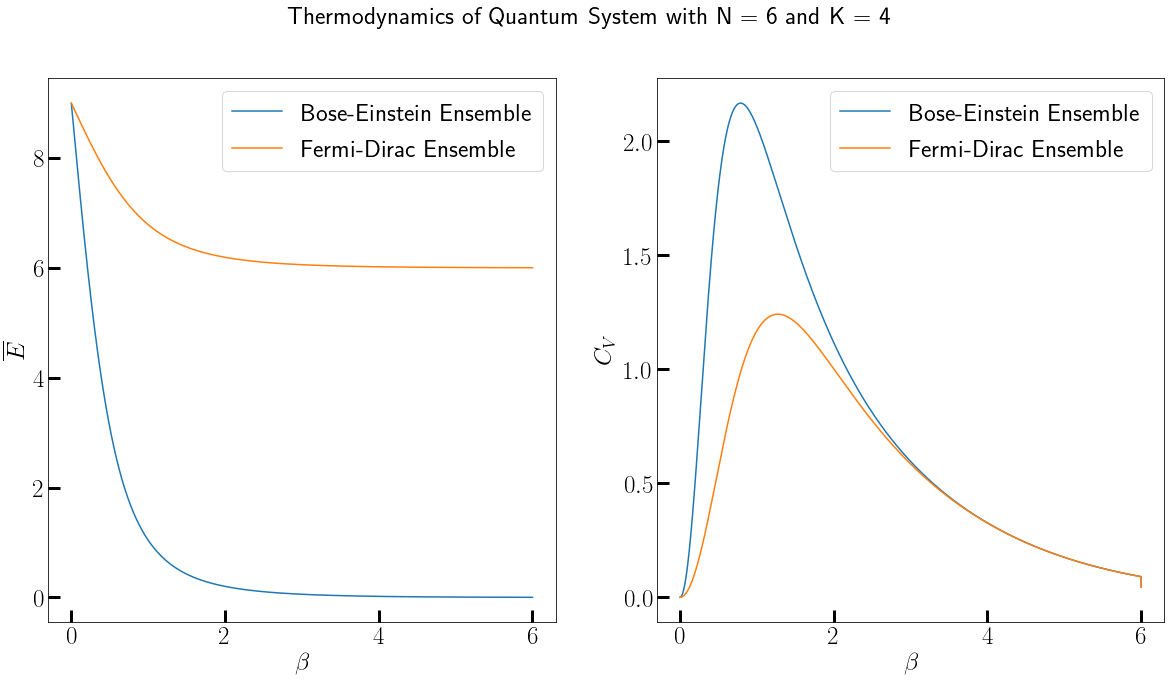

In [1]:
import numpy as np
from scipy.special import comb
from itertools import combinations_with_replacement as cwr
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Bitstream Vera Sans']})
rc('text', usetex=True)
fs = 25

##Spin of the fermions
s = 1./2.
g = int(2*s + 1)
##Number of particles
n=6
##Number of single particle energy levels
k=4
##Single particle energy levels
sp_energies = np.arange(k)
##Range of inverse temperatures
betas = np.linspace(1e-4, 6.0, 10000)


def partitions(n, b):
    '''
    Returns a matrix of configurations of n objects with b partitions
    '''
    ncr = int(comb(n+b-1, b-1))
    partition_array = np.empty((ncr, b), dtype=int)
    masks = np.identity(b, dtype=int)
    for i, c in enumerate(cwr(masks, n)): 
        partition_array[i,:] = sum(c)
    return partition_array

def PartFn(beta, ensemble, sp_energies):
    '''
    Returns the partition function at inv temp beta for an ensemble matrix
    with given single particle energies 
    '''
    many_body_energies = np.dot(ensemble, sp_energies)
    Z = np.sum(np.exp(-beta * many_body_energies))
    return Z

##This is the full Bose-Einstein ensemble
##Each row is a fock state
ens_be = partitions(n,k)

##This is the full Fermi-Dirac ensemble
##Copy the BE ensemble into the FD ensemble and exclude rows 
##with more than 'g' particles in a state
ens_fd = partitions(n,k)
ens_fd = ens_fd[np.prod(ens_fd<=g, axis=1).astype(bool)]

zvals_be = np.array([PartFn(b, ens_be, sp_energies) for b in betas])
energies_be = - np.gradient(np.log(zvals_be), betas)
cv_be = -betas**2 * np.gradient(energies_be, betas)

zvals_fd = np.array([PartFn(b, ens_fd, sp_energies) for b in betas])
energies_fd = - np.gradient(np.log(zvals_fd), betas)
cv_fd = -betas**2 * np.gradient(energies_fd, betas)


fig, axs = plt.subplots(1, 2,figsize=(20, 10))
fig.suptitle('Thermodynamics of Quantum System with N = %ld and K = %ld' % (n,k), fontsize=fs)

for ax in axs:
    ax.tick_params(direction='in', length=12, width=3, labelsize=fs)
    ax.set_xlabel(r"$\beta$", fontsize=fs)

axs[0].plot(betas, energies_be, label="Bose-Einstein Ensemble")
axs[0].plot(betas, energies_fd, label="Fermi-Dirac Ensemble")
axs[0].set_ylabel(r"$\overline{E}$", fontsize=fs)
axs[0].legend(fontsize=fs)

axs[1].plot(betas, cv_be, label="Bose-Einstein Ensemble")
axs[1].plot(betas, cv_fd, label="Fermi-Dirac Ensemble")
axs[1].set_ylabel(r"$C_V$", fontsize=fs)
axs[1].legend(fontsize=fs)
plt.show()

## Exercises:
* Run the code above by loading it into [Jupyter](https://jupyter.org/), clicking on the code cell and pressing 'Shift-Enter'. Make suitable changes to the code and run it for $N=2$, $K=2$. Compute analytical formulae for the partition funcion for the Bose-einstein and Fermi-Dirac cases and plot the results $\overline{E}$ and $C_V$ in the graphs above. Compare the analytical and numerical results.

* Start a new code cell below and plot the specific heat for as function of inverse temperature $\beta$ for several numbers of bosons in $8$ single particle states. Plot specific heats for, say, $N= 5, 8, 10, 20, 30$. What happens to the peak in the specific heat curve as $N$ increases? What do you think will happen to the peak in the thermodynamic limit?

* The above code was for an Einstein Solid, where single particle energy levels are integers. Change this to model the energy levels of a particle in a box and re-run for $N=6$, $K=4$. Compare with the Einstein Solid.  

* Make changes to the code above to build a Maxwell-Boltzman (MB) ensemble in addition to the Fermi-Dirac (FD) and Bose-Einstein (BE) ensembles, and add plots for $\overline{E}$ and $C_v$ for that case. Note that the only difference between MB and BE is that each fock state has a degeneracy associated with it, given by the number of ways that identical particles (which are distinguishable in the MB ensemble) can be permuted in a particular fock state. Modify the 'PartFn' function accordingly and compare plots with the FD and BE ensembles.